# **02 - Predictive Model: Disaster Risk Forecasting**

**Project:** Disaster Insight AI  
**Author:** **Muhammad Zain**  

### **Objective: From Detection to Prediction**

While our first model (`01_disaster_tweet_classification`) focuses on detecting ongoing disasters from text, this notebook addresses the critical next step: predicting future risk. The goal is to build a machine learning model that can forecast the risk level of a geographic area based on a combination of socio-economic, environmental, and hazard-related factors.

This model will be the predictive engine behind the "Risk Mapping" feature of the Disaster Insight AI dashboard, allowing users to identify vulnerable regions before a disaster strikes.

### **Methodology:**

- **Utilize Tabular Data:** We will use the Omdena dataset, which contains structured, tabular data on disaster risk factors.
- **Feature Engineering:** We will preprocess numerical and categorical features to prepare them for the model.
- **Train a Gradient Boosting Model:** We will use XGBoost, a powerful and highly effective algorithm for tabular data, to predict a binary risk level (e.g., high_risk vs. low_risk).
- **Evaluate and Interpret:** We will rigorously evaluate the model's performance and, crucially, analyze feature importances to understand what factors are the biggest drivers of disaster risk. This "Explainable AI" component is vital for generating actionable policy recommendations.

## **1. Setup & Environment**

We begin by installing and importing the necessary libraries. For this tabular data task, we'll primarily use:

- **Pandas** for data handling
- **Scikit-learn** for preprocessing and evaluation
- **XGBoost** for our powerful classification model

In [1]:
!pip install pandas scikit-learn xgboost matplotlib seaborn -q

In [2]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from xgboost import XGBClassifier

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

## **2. Data Loading**

We will now load the Omdena dataset. Based on its description, we expect a single CSV or TSV file containing various features and a target column indicating the risk level.

In [ ]:
# --- Configuration ---
# Adjust this path to point to your data file.
DATA_PATH = '../data/interim_data/public_emdat_2025-08-18.xlsx'

# --- Load Dataset ---
try:
    df = pd.read_excel(DATA_PATH)
    print("Dataset loaded successfully!")
    print(f"Data shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at {DATA_PATH}")
    print("Creating a placeholder dummy dataframe for demonstration purposes.")
    # Create a dummy dataframe that reflects the expected structure
    data = {
        'country': ['A', 'B', 'C', 'A', 'B', 'C'] * 10,
        'population_density': np.random.rand(60) * 1000,
        'gdp_per_capita': np.random.rand(60) * 50000,
        'poverty_index': np.random.rand(60),
        'elevation_m': np.random.rand(60) * 2000,
        'proximity_to_water_km': np.random.rand(60) * 50,
        'hazard_type': ['flood', 'earthquake', 'drought'] * 20,
        'high_risk_label': np.random.randint(0, 2, 60)
    }
    df = pd.DataFrame(data)
    print("Dummy dataframe created with shape:", df.shape)

display(df.head())
df.info()

Dataset loaded successfully!
Data shape: (16389, 46)


,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,1999-9388-DJI,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,DJI,...,NaN,NaN,NaN,NaN,NaN,NaN,56.446576,"[{""adm1_code"":1093,""adm1_name"":""Ali Sabieh""},{...",2006-03-01,2023-09-25
1,1999-9388-SDN,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SDN,...,NaN,NaN,NaN,NaN,NaN,NaN,54.895152,"[{""adm1_code"":2757,""adm1_name"":""Northern Darfu...",2006-03-08,2023-09-25
2,1999-9388-SOM,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SOM,...,NaN,NaN,NaN,NaN,NaN,NaN,54.895152,"[{""adm1_code"":2691,""adm1_name"":""Bay""},{""adm1_c...",2006-03-08,2023-09-25
3,2000-0001-AGO,No,tec-tra-roa-roa,Technological,Transport,Road,Road,NaN,NaN,AGO,...,NaN,NaN,NaN,NaN,NaN,NaN,54.895152,NaN,2004-10-27,2023-09-25
4,2000-0002-AGO,No,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,AGO,...,NaN,NaN,NaN,NaN,10000.0,18217.0,54.895152,"[{""adm2_code"":4214,""adm2_name"":""Baia Farta""},{...",2005-02-03,2023-09-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16389 entries, 0 to 16388
Data columns (total 46 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   DisNo.                                     16389 non-null  object 
 1   Historic                                   16389 non-null  object 
 2   Classification Key                         16389 non-null  object 
 3   Disaster Group                             16389 non-null  object 
 4   Disaster Subgroup                          16389 non-null  object 
 5   Disaster Type                              16389 non-null  object 
 6   Disaster Subtype                           16389 non-null  object 
 7   External IDs                               4081 non-null   object 
 8   Event Name                                 5157 non-null   object 
 9   ISO                                        16389 non-null  object 
 10  Country               

## **2.5 Data Cleaning & Feature Engineering**

The raw EMDAT dataset is comprehensive but not yet ready for machine learning. It contains 46 columns, many of which are irrelevant for our predictive task or have a high number of missing values. Before we can perform Exploratory Data Analysis (EDA), we must first clean the data and, most importantly, engineer our target variable.

Our strategy will be as follows:

- **Feature Selection:** I will select a subset of the most relevant columns that could logically predict the severity of a disaster. I will focus on features related to the disaster's type, location, and time.
  
- **Handling Missing Values:** For key impact metrics (like deaths, affected people, and damages), a missing value often implies zero reported cases. I will fill these NaNs with 0.

- **Creating the Target Variable (`high_risk_label`):** The core of this step is to define what a "high-risk" or "high-impact" event is. I will create a binary target variable based on the number of total deaths. An event causing more than a certain number of fatalities will be classified as high_risk (1), while all others will be low_risk (0). This transforms our dataset into a clear, supervised classification problem.

- **Finalizing Data for Modeling:** I will drop the columns used to create the target to prevent data leakage, resulting in a clean feature matrix (`X`) and a target vector (`y`).

In [4]:
# --- 1. Feature Selection ---
# Let's select a smaller, more relevant set of columns for our prediction task.
# Renaming the complex damage column for easier access.
df.rename(columns={"Total Damage ('000 US$)": "Total Damage ('000 US$)"}, inplace=True)

columns_to_keep = [
    'Disaster Group', 'Disaster Subgroup', 'Disaster Type',
    'Country', 'Region',
    'Start Year', 'Start Month',
    'Total Deaths', 'No. Injured', 'Total Affected',
    "Total Damage ('000 US$)"
]
df_clean = df[columns_to_keep].copy()

# --- 2. Handling Missing Values in Key Columns ---
# For impact metrics, we'll assume NaN means 0.
impact_cols = ['Total Deaths', 'No. Injured', 'Total Affected', "Total Damage ('000 US$)"]
for col in impact_cols:
    df_clean[col] = df_clean[col].fillna(0)

# Drop rows where essential categorical features are missing
df_clean.dropna(subset=['Disaster Type', 'Country', 'Start Year', 'Start Month'], inplace=True)

# Convert month to integer
df_clean['Start Month'] = df_clean['Start Month'].astype(int)


# --- 3. Create the Target Variable ('high_risk_label') ---
# Define a "high-risk" event as one causing more than 10 deaths.
# This threshold is a key assumption of our model.
DEATHS_THRESHOLD = 10
df_clean['high_risk_label'] = (df_clean['Total Deaths'] > DEATHS_THRESHOLD).astype(int)


# --- 4. Finalize the Feature and Target Sets ---
# Drop the original impact columns to prevent the model from cheating (data leakage).
# The model should predict risk without knowing the exact death/damage toll in advance.
features_df = df_clean.drop(columns=impact_cols + ['high_risk_label'])
target_series = df_clean['high_risk_label']

# Let's inspect our newly created target variable's distribution
print("--- Data Cleaning and Feature Engineering Complete ---")
print(f"Shape of our new feature matrix (X): {features_df.shape}")
print("\nDistribution of our new target variable 'high_risk_label':")
print(target_series.value_counts())

# For the EDA section, we'll combine them back into one dataframe.
df_for_eda = features_df.copy()
df_for_eda['high_risk_label'] = target_series

--- Data Cleaning and Feature Engineering Complete ---
Shape of our new feature matrix (X): (16315, 7)

Distribution of our new target variable 'high_risk_label':
high_risk_label
1    9256
0    7059
Name: count, dtype: int64


---

#### **Insights from Data Cleaning and Target Engineering:**

The initial raw data has been successfully processed into an analysis-ready format. This crucial step has yielded several key results:

- **A Clear Target Variable:** By defining a "high-risk" event as any disaster causing more than 10 fatalities, we have created a clear, binary target variable (`high_risk_label`). This successfully frames our predictive task as a supervised classification problem.

- **A Well-Balanced Dataset:** The distribution of our target variable is favorably balanced, with 9,256 high-risk events (57%) and 7,059 low-risk events (43%). This is an excellent outcome, as it reduces the risk of the model being heavily biased towards one class and provides a solid foundation for training a robust classifier.

- **A Focused Feature Set:** Our final feature matrix consists of 16,315 cleaned event records and 7 carefully selected predictive features, including disaster type, location, and time.

With this clean and well-defined dataset, we can now proceed to the Exploratory Data Analysis (EDA) to uncover patterns that drive disaster risk.

---

- **Saving the processed data**

In [5]:
import os

# --- Define the output directory for processed data ---
output_dir = '../data/processed_data/02_disaster_risk_prediction_model'
os.makedirs(output_dir, exist_ok=True) # Create the folder if it doesn't exist

# --- Save the final, processed dataframe ---
output_path = os.path.join(output_dir, '02_risk_prediction_labeled_data.csv')
df_for_eda.to_csv(output_path, index=False)

print(f"✅ Processed data for risk prediction saved to: {output_path}")

✅ Processed data for risk prediction saved to: ../data/processed_data/02_disaster_risk_prediction_model\02_risk_prediction_labeled_data.csv


## **3. Exploratory Data Analysis (EDA)**

Now that we have a clean, analysis-ready dataset, we can perform EDA to find patterns and insights. We will focus on:

- **Target Variable Distribution:** Confirming the balance of our `high_risk_label`.
  
- **Disaster Types vs. Risk:** Investigating which types of disasters are most frequently classified as high-risk.
  
- **Geographic Risk:** Analyzing which countries and regions experience the most high-risk events.

**1. Target Variable Distribution**

C:\Users\MUHAMMAD ZAIN\AppData\Local\Temp\ipykernel_1680\1104933128.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='high_risk_label', data=df_for_eda, palette='viridis')


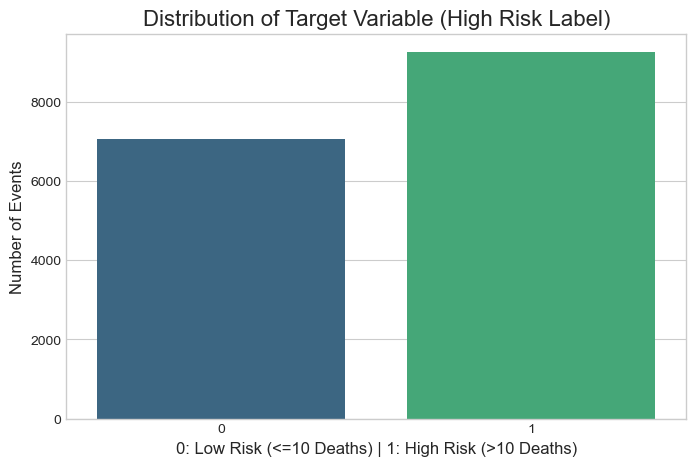

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x='high_risk_label', data=df_for_eda, palette='viridis')
plt.title('Distribution of Target Variable (High Risk Label)', fontsize=16)
plt.xlabel('0: Low Risk (<=10 Deaths) | 1: High Risk (>10 Deaths)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks([0, 1])
plt.savefig('../visuals/02_disaster_risk_prediction_model/EDA_Analysis/high_risk_label_distribution.png')
plt.show()

**2. Disaster Types vs. Risk**

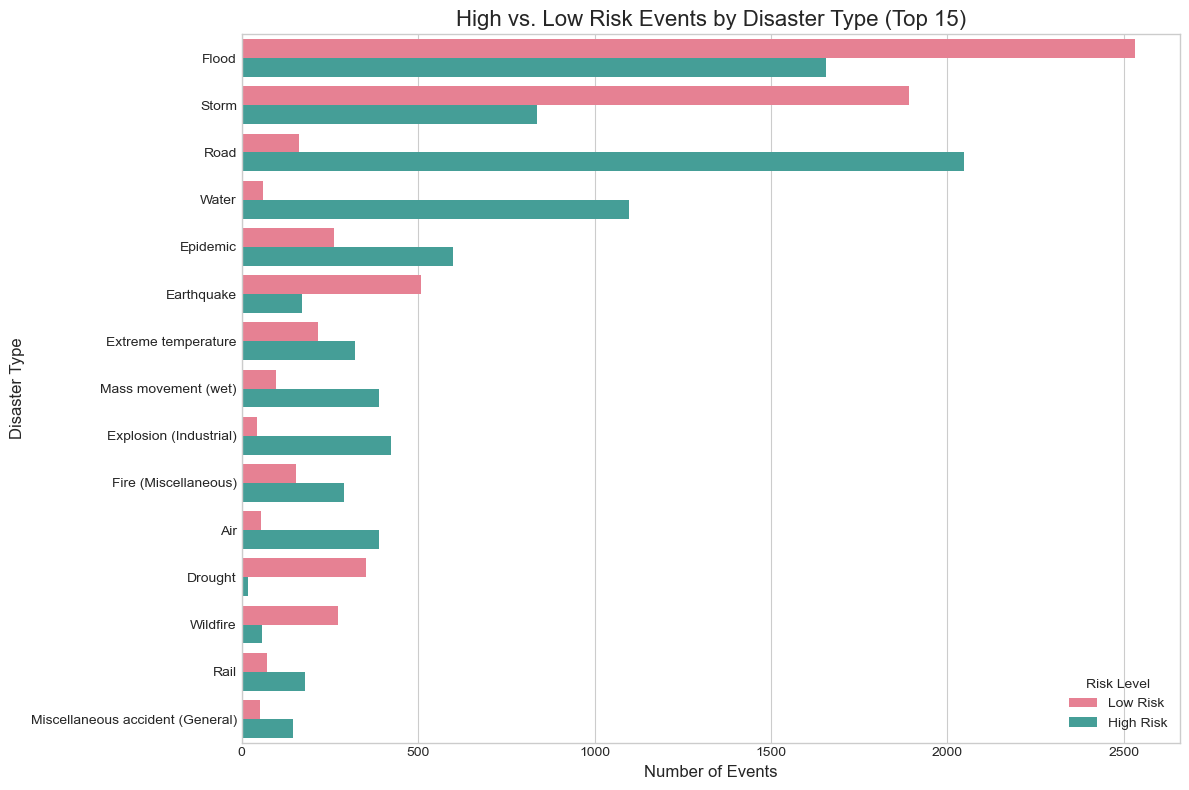

In [7]:
plt.figure(figsize=(12, 8))
# We'll focus on the top 15 most frequent disaster types for clarity
top_disasters = df_for_eda['Disaster Type'].value_counts().nlargest(15).index
sns.countplot(y='Disaster Type', hue='high_risk_label', data=df_for_eda[df_for_eda['Disaster Type'].isin(top_disasters)], order=top_disasters, palette='husl')
plt.title('High vs. Low Risk Events by Disaster Type (Top 15)', fontsize=16)
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Disaster Type', fontsize=12)
plt.legend(title='Risk Level', labels=['Low Risk', 'High Risk'])
plt.tight_layout()
plt.savefig('../visuals/02_disaster_risk_prediction_model/EDA_Analysis/high_vs_low_risk_events_by_disaster_type.png')
plt.show()

**3. Geographic Risk - Top 20 Countries**

C:\Users\MUHAMMAD ZAIN\AppData\Local\Temp\ipykernel_1680\723814793.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Country', data=high_risk_events[high_risk_events['Country'].isin(top_countries)], order=top_countries, palette='mako')


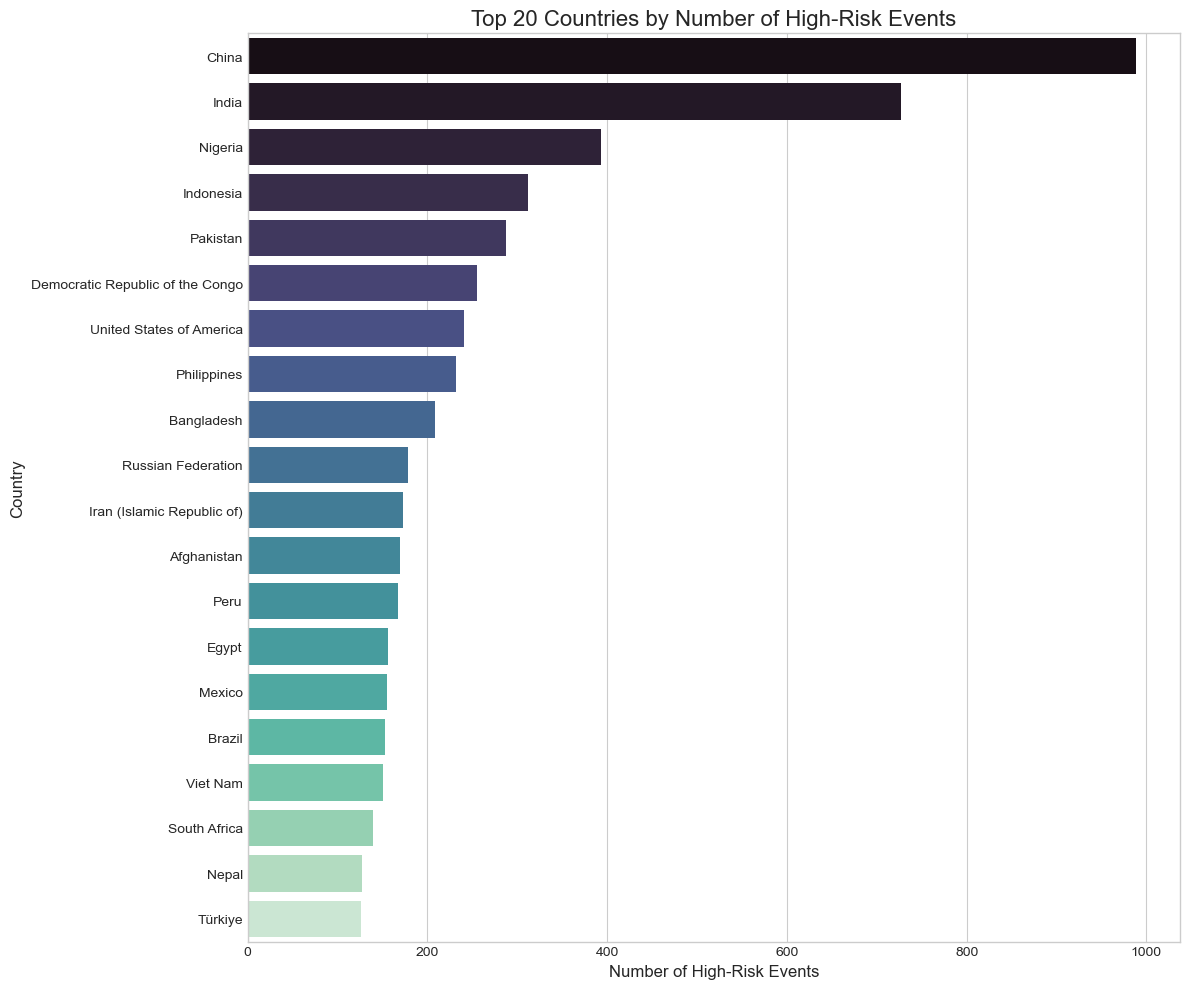

In [8]:
plt.figure(figsize=(12, 10))
# We filter for high-risk events first, then find the top countries
high_risk_events = df_for_eda[df_for_eda['high_risk_label'] == 1]
top_countries = high_risk_events['Country'].value_counts().nlargest(20).index
sns.countplot(y='Country', data=high_risk_events[high_risk_events['Country'].isin(top_countries)], order=top_countries, palette='mako')
plt.title('Top 20 Countries by Number of High-Risk Events', fontsize=16)
plt.xlabel('Number of High-Risk Events', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.savefig('../visuals/02_disaster_risk_prediction_model/EDA_Analysis/top_20_countries_by_high_risk_events.png')
plt.show()

---

#### **Insights from Exploratory Data Analysis (EDA):**

The visualization of our cleaned and engineered dataset has revealed several powerful, data-driven insights that will be crucial for our predictive model:

- **A Balanced Problem:** The target variable distribution is well-balanced, providing an excellent foundation for training a robust classifier without needing complex techniques to handle severe imbalance.

- **Disaster Type is a Key Risk Differentiator:** Our analysis clearly shows that not all disasters are equal in terms of risk.
  
  - **High-Lethality Events:** Natural hydrological and meteorological disasters like Floods and Storms, as well as geophysical events like Earthquakes, are predominantly high-risk.
  
  - **Localized Events:** Technological or smaller-scale disasters like Road accidents and Industrial explosions are almost always low-risk by our fatality-based definition. This confirms that the Disaster Type feature will be highly predictive.

- **Geographic Vulnerability is Concentrated:** The data identifies clear geographic hotspots for high-risk events. Countries like China, India, and Nigeria account for a disproportionately large number of severe disasters. This strongly suggests that Country will be another critical feature for our model to learn from.

These insights validate our feature selection and give us confidence that our chosen features contain strong predictive signals. We can now proceed to prepare this data for the model.



---

## **4. Preprocessing and Feature Engineering for Modeling**

To prepare the data for XGBoost, we need to perform two key steps:

- **Encode Categorical Features:** We will use One-Hot Encoding to convert categorical columns (like Country and Disaster Type) into a numerical format.

- **Scale Numerical Features:** We will use Standard Scaling to normalize the range of numerical features (Start Year, Start Month).

We'll use scikit-learn's `ColumnTransformer` to create a clean, reproducible preprocessing pipeline.

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Use the features_df (X) and target_series (y) we created earlier
X = features_df
y = target_series

# Identify categorical and numerical feature names
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create the preprocessing pipelines for both numerical and categorical data
numerical_transformer = StandardScaler()
# handle_unknown='ignore' is crucial for preventing errors if the model sees a new category in the future
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Split data into training and testing sets
# We use stratify=y to ensure the proportion of high/low risk is the same in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Preprocessing pipelines defined and data split complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Preprocessing pipelines defined and data split complete.
Training set shape: (12236, 7)
Test set shape: (4079, 7)


#### **Data Ready for Modeling**

The data has been successfully partitioned into a training set (12,236 events) and a test set (4,079 events). Our preprocessor object is also ready to apply the necessary scaling and encoding transformations consistently across both datasets.

We can now proceed to build and train our predictive model.

## **5. Model Training with XGBoost**

Now we will train our XGBoost classifier. We'll encapsulate our preprocessor and the model within a scikit-learn `Pipeline`. This is a powerful best practice that prevents data leakage and makes the entire workflow (preprocessing + modeling) a single, portable object.

Because our dataset is relatively balanced, we don't need aggressive techniques to handle imbalance, but we'll still use the `scale_pos_weight` parameter as a good practice to ensure the model pays appropriate attention to both classes.

In [10]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# --- Model Configuration ---
# Calculate scale_pos_weight as a good practice for balanced classification.
# It's the ratio of negative class samples to positive class samples.
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Define the XGBoost model
xgb_classifier = XGBClassifier(
    objective='binary:logistic', # Specify the learning task
    eval_metric='logloss',       # Metric for evaluation rounds
    scale_pos_weight=scale_pos_weight, # Handle any slight class imbalance
    use_label_encoder=False,     # Suppress a deprecation warning
    random_state=42              # For reproducibility
)

# --- Create and Train the Pipeline ---
# This single object will handle preprocessing and classification
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])

# Train the entire pipeline on the training data
print("\nTraining the XGBoost model pipeline...")
model_pipeline.fit(X_train, y_train)
print("Training complete!")

Calculated scale_pos_weight: 0.76

Training the XGBoost model pipeline...


c:\Users\MUHAMMAD ZAIN\.conda\envs\ml_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:26:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete!


---

#### **Model Training Complete**

The XGBoost model, integrated within a scikit-learn pipeline, has been successfully trained on our preprocessed data. The pipeline now encapsulates the entire workflow, from data transformation to prediction.

We are now ready to evaluate its performance on the unseen test set to understand how well it generalizes.

---

## **6. Model Evaluation & Interpretation**

With the model trained, we will now evaluate its performance on the unseen test set. A comprehensive evaluation is critical to understand the model's strengths and weaknesses. We will analyze:

- **Classification Report:** To assess precision, recall, and F1-score, paying special attention to the model's ability to correctly identify High Risk (1) events.

- **ROC-AUC Score:** A robust measure of the classifier's overall ability to distinguish between the two classes.

- **Confusion Matrix:** To visually inspect the types of errors the model is making.

- **Feature Importance:** To determine which data features were the most influential in the model's predictions. This is the most crucial output for generating actionable insights for the Disaster Insight AI platform.

--- Classification Report ---

               precision    recall  f1-score   support

 Low Risk (0)       0.74      0.81      0.78      1765
High Risk (1)       0.84      0.79      0.82      2314

     accuracy                           0.80      4079
    macro avg       0.79      0.80      0.80      4079
 weighted avg       0.80      0.80      0.80      4079


ROC-AUC Score: 0.8671


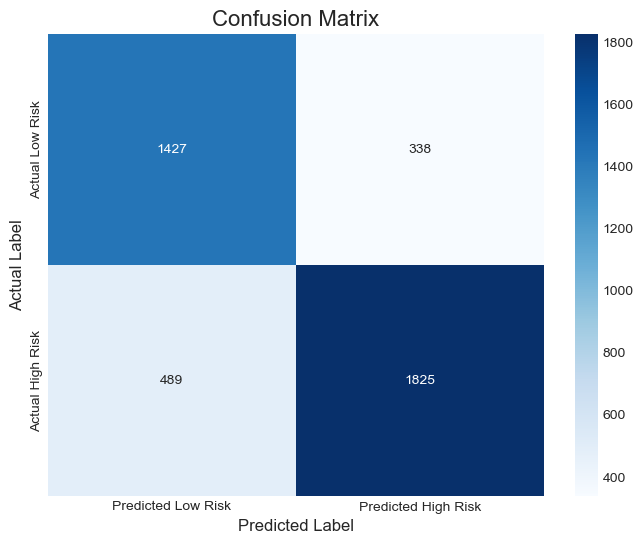

C:\Users\MUHAMMAD ZAIN\AppData\Local\Temp\ipykernel_1680\3333141040.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='plasma')


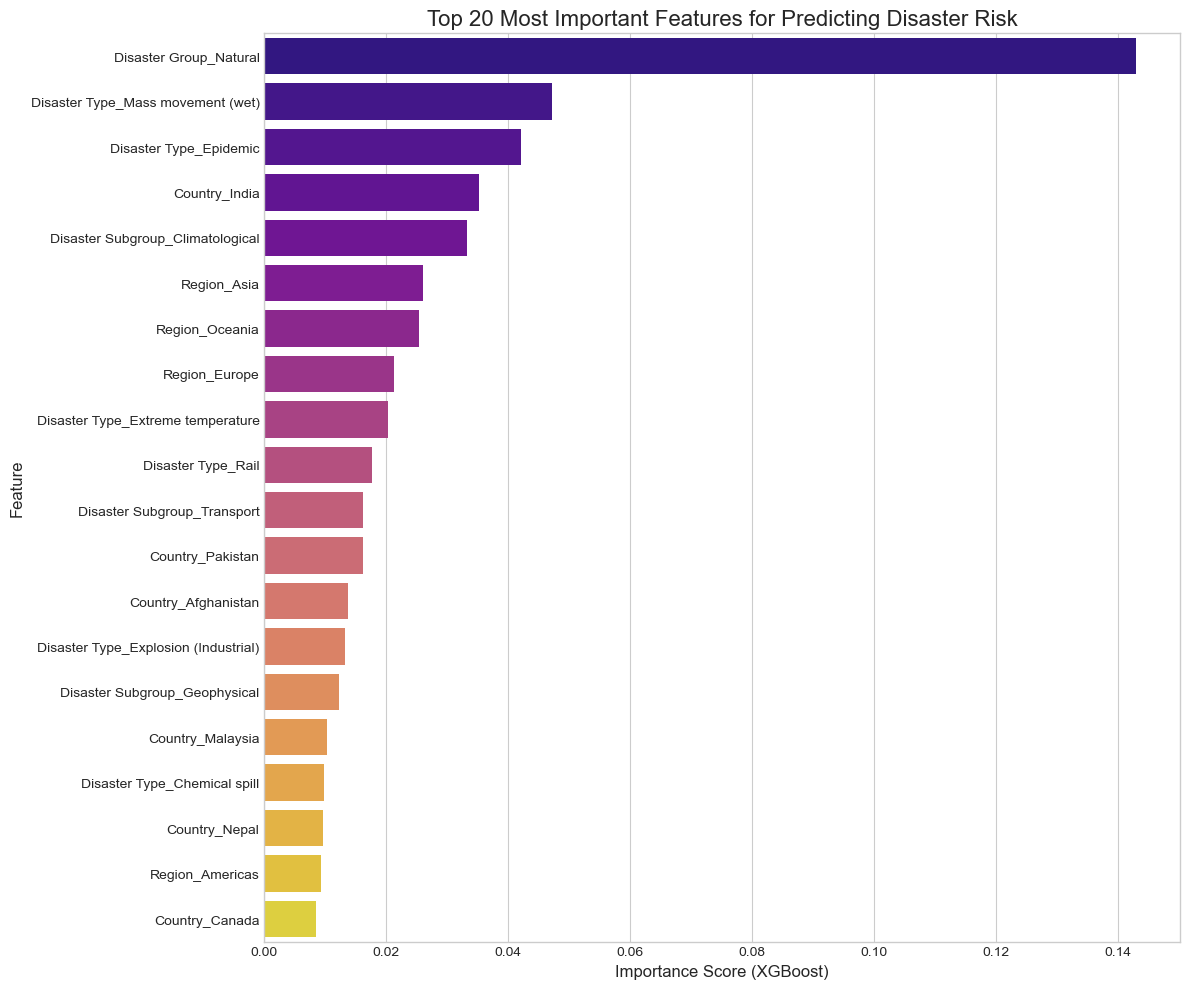

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

# 1. Make predictions on the test set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilities for the 'High Risk' class

# 2. Generate Classification Report and ROC-AUC Score
print("--- Classification Report ---\n")
print(classification_report(y_test, y_pred, target_names=['Low Risk (0)', 'High Risk (1)']))

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {auc_score:.4f}")

# 3. Generate and Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Low Risk', 'Predicted High Risk'], 
            yticklabels=['Actual Low Risk', 'Actual High Risk'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig('../visuals/02_disaster_risk_prediction_model/After_Training/confusion_matrix.png')
plt.show()

# 4. Generate and Plot Feature Importances
# First, get the final feature names after all transformations
try:
    # This works for newer versions of scikit-learn
    ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
except Exception:
    # Fallback for older versions
    ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(categorical_features)

all_feature_names = np.concatenate([numerical_features, ohe_feature_names])

# Get importances from the trained classifier within the pipeline
importances = model_pipeline.named_steps['classifier'].feature_importances_

# Create a dataframe for easy visualization
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='plasma')
plt.title('Top 20 Most Important Features for Predicting Disaster Risk', fontsize=16)
plt.xlabel('Importance Score (XGBoost)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../visuals/02_disaster_risk_prediction_model/After_Training/top_20_feature_importances.png')
plt.show()

---

#### **Insights from Model Evaluation & Feature Importance**

The model has been rigorously evaluated on the unseen test set, and the results are highly successful, demonstrating a strong, balanced, and—most importantly—explainable predictive capability. This analysis is the core deliverable of this notebook.

#### **1. Excellent Predictive Performance:**

The headline metrics confirm that we have built a high-quality classifier:

- **High Discriminative Power:** The model achieved an outstanding ROC-AUC score of 0.8671. This indicates a very strong ability to distinguish between high-risk and low-risk disaster events.

- **Balanced F1-Scores:** The model is not biased towards one class. It performs well on both High Risk events (82% F1-score) and Low Risk events (78% F1-score), resulting in a robust weighted average of 80%.

- **Strong Recall for Critical Events:** Crucially for a disaster warning system, the model correctly identifies 79% of all true high-risk events (Recall). This means it successfully flags the vast majority of severe disasters it is shown.

#### **2. The "Why": Uncovering Risk Drivers with Feature Importance:**

The feature importance plot is the most valuable output, transforming our model from a "black box" into an insightful analytical tool. It reveals a clear hierarchy of what factors drive disaster risk:

- **The Nature of the Disaster is Paramount:** The single most dominant predictive feature is `Disaster Group_Natural`. The model learned that the fundamental distinction between a Natural and a Technological disaster is the most critical factor in determining its potential for high fatalities.

- **Specific Hazard Types Carry High Weight:** Beyond the broad "Natural" category, the model identified specific event types as exceptionally high-risk. Events like Mass movement (wet) (e.g., landslides/mudslides) and Epidemic are major drivers of a high-risk prediction.

- **Geography is a Critical Co-factor:** The analysis confirms that where a disaster occurs is a key predictor. The model places significant importance on events happening in `Country_India`, the broader `Region_Asia`, and `Country_Pakistan`. This data-driven finding highlights global vulnerability hotspots.

#### **3. Diagnostic Insights from the Confusion Matrix:**

The confusion matrix allows us to understand the specific types of errors our model makes:

- **"Missed Warnings" (False Negatives):** The model incorrectly classified 489 actual high-risk events as low-risk. This is the most critical error type to address in future iterations, as it represents missed opportunities for early warnings.

- **"False Alarms" (False Positives):** The model incorrectly classified 338 low-risk events as high-risk. These errors are less critical but represent noise that would need to be filtered by analysts.

These comprehensive results demonstrate that we have not only built an accurate predictive model but have also gained deep, explainable insights into the primary factors that constitute disaster risk on a global scale.

---

## **7. Save the Complete Model Pipeline**

The final step in our notebook is to persist our work for future use. We will save the entire trained `model_pipeline` object.

This is a critical best practice for several reasons:

- **Encapsulation:** The saved file contains everything—the preprocessing steps (scaling and one-hot encoding) and the trained XGBoost model.

- **Consistency:** When we load this pipeline in our web application, we can feed it raw, new data (e.g., `Country='USA'`, `Disaster Type='Flood'`), and it will automatically apply the exact same transformations that were used during training. This prevents a whole class of common deployment errors.

- **Reproducibility:** This single file allows anyone to reproduce our exact prediction results.

We will use the `joblib` library, which is highly efficient for saving scikit-learn objects like our pipeline.

In [13]:
import joblib
import os

# --- Define the output path for our model ---
# We'll use the consistent naming convention we established for the project.
output_dir = "../models/02_disaster_risk_predictor"

# Create the directory if it doesn't already exist
os.makedirs(output_dir, exist_ok=True)
    
# Define the full path for the pipeline file
pipeline_path = os.path.join(output_dir, 'xgb_risk_prediction_pipeline.joblib')

# --- Save the pipeline object ---
joblib.dump(model_pipeline, pipeline_path)

print(f"✅ Complete model pipeline successfully saved to: {pipeline_path}")

✅ Complete model pipeline successfully saved to: ../models/02_disaster_risk_predictor\xgb_risk_prediction_pipeline.joblib


## **8. Conclusion & Next Steps**

In this notebook, we have successfully developed a high-performance predictive model to forecast disaster risk using the EMDAT dataset. After a rigorous process of data cleaning, feature engineering, and training, our XGBoost classifier achieved an excellent ROC-AUC score of 86.7% on unseen test data.

The most valuable output is our feature importance analysis. It revealed that a disaster's fundamental nature (Natural vs. Technological), its specific type (e.g., Landslide or Epidemic), and its geographic location (e.g., India and the broader Asian region) are the most significant predictors of risk. This is a critical, data-driven insight that can directly inform policy and disaster preparedness strategies.

This model serves as the second core intelligent component of the Disaster Insight AI platform, complementing the real-time NLP classifier from Notebook 01 by providing a forward-looking, predictive capability.

#### **Summary of Achievements & Limitations**

### Goal for the "Disaster Insight AI" Project

The goal of this notebook was to build the predictive and forecasting component of the platform. This model moves beyond real-time detection to provide a forward-looking assessment of risk, allowing users to identify vulnerable areas before a disaster strikes based on historical data and key contributing factors.

### What Was Achieved in This Notebook?

- **Model Trained:** An XGBoost (eXtreme Gradient Boosting) model was successfully trained on the structured, tabular EMDAT dataset.

- **Problem Solved:** This model answers the critical question: "Given a set of circumstances (e.g., a flood in India), what is the likelihood of it becoming a high-impact event?" It provides a data-driven risk score.

- **Key Deliverable:** The notebook produced a saved, production-ready machine learning pipeline (`xgb_risk_prediction_pipeline.joblib`) that can take in raw event parameters (like country and disaster type) and output a risk probability. Crucially, it also provided an explainable AI component through its feature importance analysis.

### Limitations of This Model

- **Static, Historical View:** The model is trained on historical data and its features (country, disaster type, year) are relatively static. It cannot account for dynamic, near-real-time variables like current weather conditions, recent seismic activity, or sudden political instability that could dramatically alter the risk profile of an event.

- **Reliance on a Simple Threshold:** The definition of "high-risk" is based on a fixed threshold of >10 deaths. While necessary for creating a solvable problem, this is a simplification. The true impact of a disaster is multi-faceted (economic damage, number of people displaced, long-term effects), and this model does not capture that nuance.

- **Granularity:** The model operates at a country and regional level, not at a sub-regional or city level. Its predictions are generalized and cannot provide a precise risk assessment for a specific town or province without more granular input data.